In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# user-friendly print
from IPython.core.interactiveshell import InteractiveShell
from pymatgen.core import Composition

from foundation_model.utils.interpolate import InterpSmooth

InteractiveShell.instance().ast_node_interactivity = "all"

In [2]:
from typing import Optional, Union


def is_empty_list(x):
    return isinstance(x, str) and x == "[]"


def convert_mass_magnetization(
    comp: Composition, mass_magnetization: Union[float, np.ndarray], cgs_to_si: bool = True
) -> Union[float, np.ndarray]:
    """
    转换质量磁化率的单位，根据布尔参数决定转换方向。
    支持 mass_magnetization 为标量或 numpy 数组的情况。

    参数:
        comp: pymatgen.core.composition.Composition
            物质的化学组成，用于计算摩尔质量 (g/mol)。
        mass_magnetization: float 或 numpy.ndarray
            - 当 cgs_to_si 为 True 时，表示 CGS 制的质量磁化率 (emu/g)；
            - 当 cgs_to_si 为 False 时，表示 SI 制的摩尔磁矩 (A·m²/mol)。
            可以是单个浮点数，也可以是 numpy 数组。
        cgs_to_si: bool, 默认 True
            转换方向选择：
                True  : 从 CGS (emu/g) 转换到 SI (A·m²/mol)
                False : 从 SI (A·m²/mol) 转换到 CGS (emu/g)

    返回:
        float 或 numpy.ndarray:
            转换后的磁化率数值。
            - 如果 cgs_to_si=True，单位为 A·m²/mol；
            - 如果 cgs_to_si=False，单位为 emu/g。
            如果输入是 numpy 数组，则返回相同形状的 numpy 数组；
            如果输入是标量，则返回标量浮点数。
    """
    # 计算摩尔质量 (g/mol)
    molar_mass = comp.weight  # g/mol

    # 将输入转为 numpy 数组以便支持数组运算
    mm_arr = np.asarray(mass_magnetization, dtype=float)

    if cgs_to_si:
        # 从 CGS 转换到 SI:
        # mass_magnetization (emu/g) * molar_mass (g/mol) = emu/mol
        # 1 emu = 1e-3 A·m², 所以转换为 SI 得到 A·m²/mol
        result_arr = mm_arr * molar_mass * 1e-3
    else:
        # 从 SI 转换到 CGS:
        # mass_magnetization 表示 SI 制 (A·m²/mol)
        # 先转换为 emu/mol: 1 A·m² = 1e3 emu, 然后除以 molar_mass (g/mol) 得到 emu/g
        result_arr = mm_arr * 1e3 / molar_mass

    # 如果输入是标量 (0 维数组)，将结果转回浮点数
    if result_arr.ndim == 0:
        return float(result_arr)
    return result_arr


def convert_composition(comp: str) -> Optional[Composition]:
    try:
        c = Composition(comp)
        if len(c) == 0:
            return None
        return c
    except Exception:
        return None


def format_title(text: str, to_snake: bool = False, skip_list: Optional[list[str]] = None) -> str:
    """
    格式化输入文本为首字母大写格式或蛇形命名法，并支持指定不需要格式化的单词。

    参数:
        text : str
            输入文本。
        to_snake : bool, 可选
            是否转换为蛇形命名法，默认为 False。
        skip_list : list[str], 可选
            指定部分单词不做格式化，默认为 None。

    返回:
        str
            格式化后的文本。
    """
    if not isinstance(text, str):
        raise ValueError("Input must be a string")

    if text is None or text.strip() == "":
        return text

    if skip_list is None:
        skip_list = []

    if to_snake:
        # 将空格拆分为单词，并转换为蛇形命名法，保留skip_list中的单词不变
        words = text.strip().split()
        formatted = [word if word in skip_list else word.lower() for word in words]
        return "_".join(formatted)
    else:
        # 将下划线替换为空格，并分割成单词
        words = text.replace("_", " ").strip().split()
        if not words:
            return text
        # 格式化：第一个单词首字母大写，其他单词全部小写（除非在skip_list中）
        formatted = []
        for i, word in enumerate(words):
            if word in skip_list:
                formatted.append(word)
            else:
                formatted.append(word.capitalize() if i == 0 else word.lower())
        return " ".join(formatted)

#### QC AC data

In [7]:
qc_ac_dataset = (
    pd.read_csv("../raw/HYPOD-X_20250121/properties_dataset.csv")
    .dropna()
    .drop(columns=["sample_name", "figure_id", "degree_of_approximant", "SID"])
)
qc_ac_dataset = qc_ac_dataset.rename(columns={"composition": "formula", "QC_or_AC_type": "hypermaterial_type"})

# Drop Specific heat since these value is to describe the temperature derivative of the molar heat capacity or the second-order temperature effects
qc_ac_dataset = qc_ac_dataset[
    ~qc_ac_dataset.prop_y.isin(["Specific heat", "Specific heat capacity", "Hall coefficient", "Thermal diffusivity"])
]

# Try to convert the composition string to the Composition object
qc_ac_dataset = qc_ac_dataset.assign(composition=qc_ac_dataset["formula"].apply(convert_composition)).dropna()
qc_ac_dataset = qc_ac_dataset.assign(
    elements=qc_ac_dataset.composition.apply(lambda c: tuple([str(e) for e in c.elements]))
)

# Align unit of Magnetic susceptibility
tmp = qc_ac_dataset[qc_ac_dataset.unit_y == "emu*g^(-1)"]
tmp = tmp.assign(
    unit_y="A*m**2/mol", y=[convert_mass_magnetization(comp, y) for comp, y in zip(tmp.composition, tmp.y)]
)
qc_ac_dataset.update(tmp)


qc_ac_dataset.unit_y.unique()
qc_ac_dataset.prop_y.unique()
qc_ac_dataset.shape
qc_ac_dataset.head(3)

array(['Ohm*m', 'W*m^(-1)*K^(-1)', 'V*K^(-1)', 'W*m^(-1)*K^(-2)', '-',
       'A*m**2/mol'], dtype=object)

array(['Electrical resistivity', 'Thermal conductivity',
       'Seebeck coefficient', 'Power factor', 'ZT',
       'Magnetic susceptibility'], dtype=object)

(49460, 12)

,formula,hypermaterial_type,prop_x,prop_y,unit_x,unit_y,x,y,sample_id,DOI,composition,elements
0,Y12Mg29Zn59,IQC,Temperature,Electrical resistivity,K,Ohm*m,9.608498,0.000002,17976,10.1063/1.1406555,"(Y, Mg, Zn)","(Y, Mg, Zn)"
1,Y12Mg29Zn59,IQC,Temperature,Electrical resistivity,K,Ohm*m,19.835030,0.000002,17976,10.1063/1.1406555,"(Y, Mg, Zn)","(Y, Mg, Zn)"
2,Y12Mg29Zn59,IQC,Temperature,Electrical resistivity,K,Ohm*m,31.782880,0.000002,17976,10.1063/1.1406555,"(Y, Mg, Zn)","(Y, Mg, Zn)"


In [80]:
start, end = 1.0, 1000.0
x_new = np.linspace(start, end, 500)  # pre-selected range = (-6,5, 10.5).

y_new_list = defaultdict(list)
qc_ac_dataset_rebuild = []
f_, p_ = "", ""
for (f, p, s), data in qc_ac_dataset.groupby(["formula", "prop_y", "sample_id"]):
    if (f_, p_) == (f, p):
        continue
    if len(data.x) <= 10:
        continue
    if max(data.x) - min(data.x) < 50.0:
        continue
    f_, p_ = f, p

    interp = InterpSmooth(data.x.to_numpy(), data.y.to_numpy(), smooth_method="savgol")
    y_sgol = interp(x_new, s_factor=30.0)
    # y_sgol = interp(x_new, s_factor=30.0, normalize=True)
    tmp = data.iloc[0].copy()
    tmp.x = data.x.tolist()
    tmp.y = data.y.tolist()
    tmp["temperature"] = x_new.tolist()
    tmp["property_value"] = y_sgol.tolist()

    qc_ac_dataset_rebuild.append(tmp)

qc_ac_dataset_rebuild = (
    pd.DataFrame(qc_ac_dataset_rebuild)
    .rename(columns={"prop_y": "property", "unit_y": "unit", "x": "raw_x", "y": "raw_y"})
    .drop(columns=["prop_x", "unit_x"])
)

# qc_ac_dataset_rebuild.property = qc_ac_dataset_rebuild.property.apply(lambda x: f"{x} (normalized)")
qc_ac_dataset_rebuild = qc_ac_dataset_rebuild.set_index([[f"qa-{i}" for i in qc_ac_dataset_rebuild.index]], drop=True)
qc_ac_dataset_rebuild.head(3)
qc_ac_dataset_rebuild.shape
qc_ac_dataset_rebuild.property.value_counts()

# Save the processed dataset
qc_ac_dataset_rebuild.to_pickle("../processed_qc_ac_dataset_20250121.pd.xz")

,formula,hypermaterial_type,property,unit,raw_x,raw_y,sample_id,DOI,composition,elements,temperature,property_value
qa-34653,Al61.5Cu26.5Fe12,IQC,Seebeck coefficient,V*K^(-1),"[100.253, 122.1073, 139.211, 159.1709, 180.081...","[-1.04e-05, -1.08e-05, -1.12e-05, -1.13e-05, -...",57966,10.1007/s11664-014-3204-4,"(Al, Cu, Fe)","(Al, Cu, Fe)","[1.0, 3.002004008016032, 5.004008016032064, 7....","[-1.0399999999999999e-05, -1.0399999999999997e..."
qa-6872,Ag42.25In42.25Yb15.5,IQC,Electrical resistivity,Ohm*m,"[5.68044, 12.19651, 18.7126, 25.22901, 31.7462...","[2.26e-06, 2.26e-06, 2.26e-06, 2.26e-06, 2.26e...",35352,10.1103/physrevb.72.054202,"(Ag, In, Yb)","(Ag, In, Yb)","[1.0, 3.002004008016032, 5.004008016032064, 7....","[2.259999999999999e-06, 2.259999999999999e-06,..."
qa-7129,Ag42.25In42.25Yb15.5,IQC,Seebeck coefficient,V*K^(-1),"[8.71879, 14.32364, 16.10026, 19.74174, 23.513...","[1.3e-06, 1.8e-06, 2.139e-06, 2.48e-06, 2.76e-...",35352,10.1103/physrevb.72.054202,"(Ag, In, Yb)","(Ag, In, Yb)","[1.0, 3.002004008016032, 5.004008016032064, 7....","[1.1352007969231425e-06, 1.221535213075527e-06..."


(654, 12)

property
Electrical resistivity     361
Seebeck coefficient        141
Thermal conductivity        72
Magnetic susceptibility     42
Power factor                25
ZT                          13
Name: count, dtype: int64

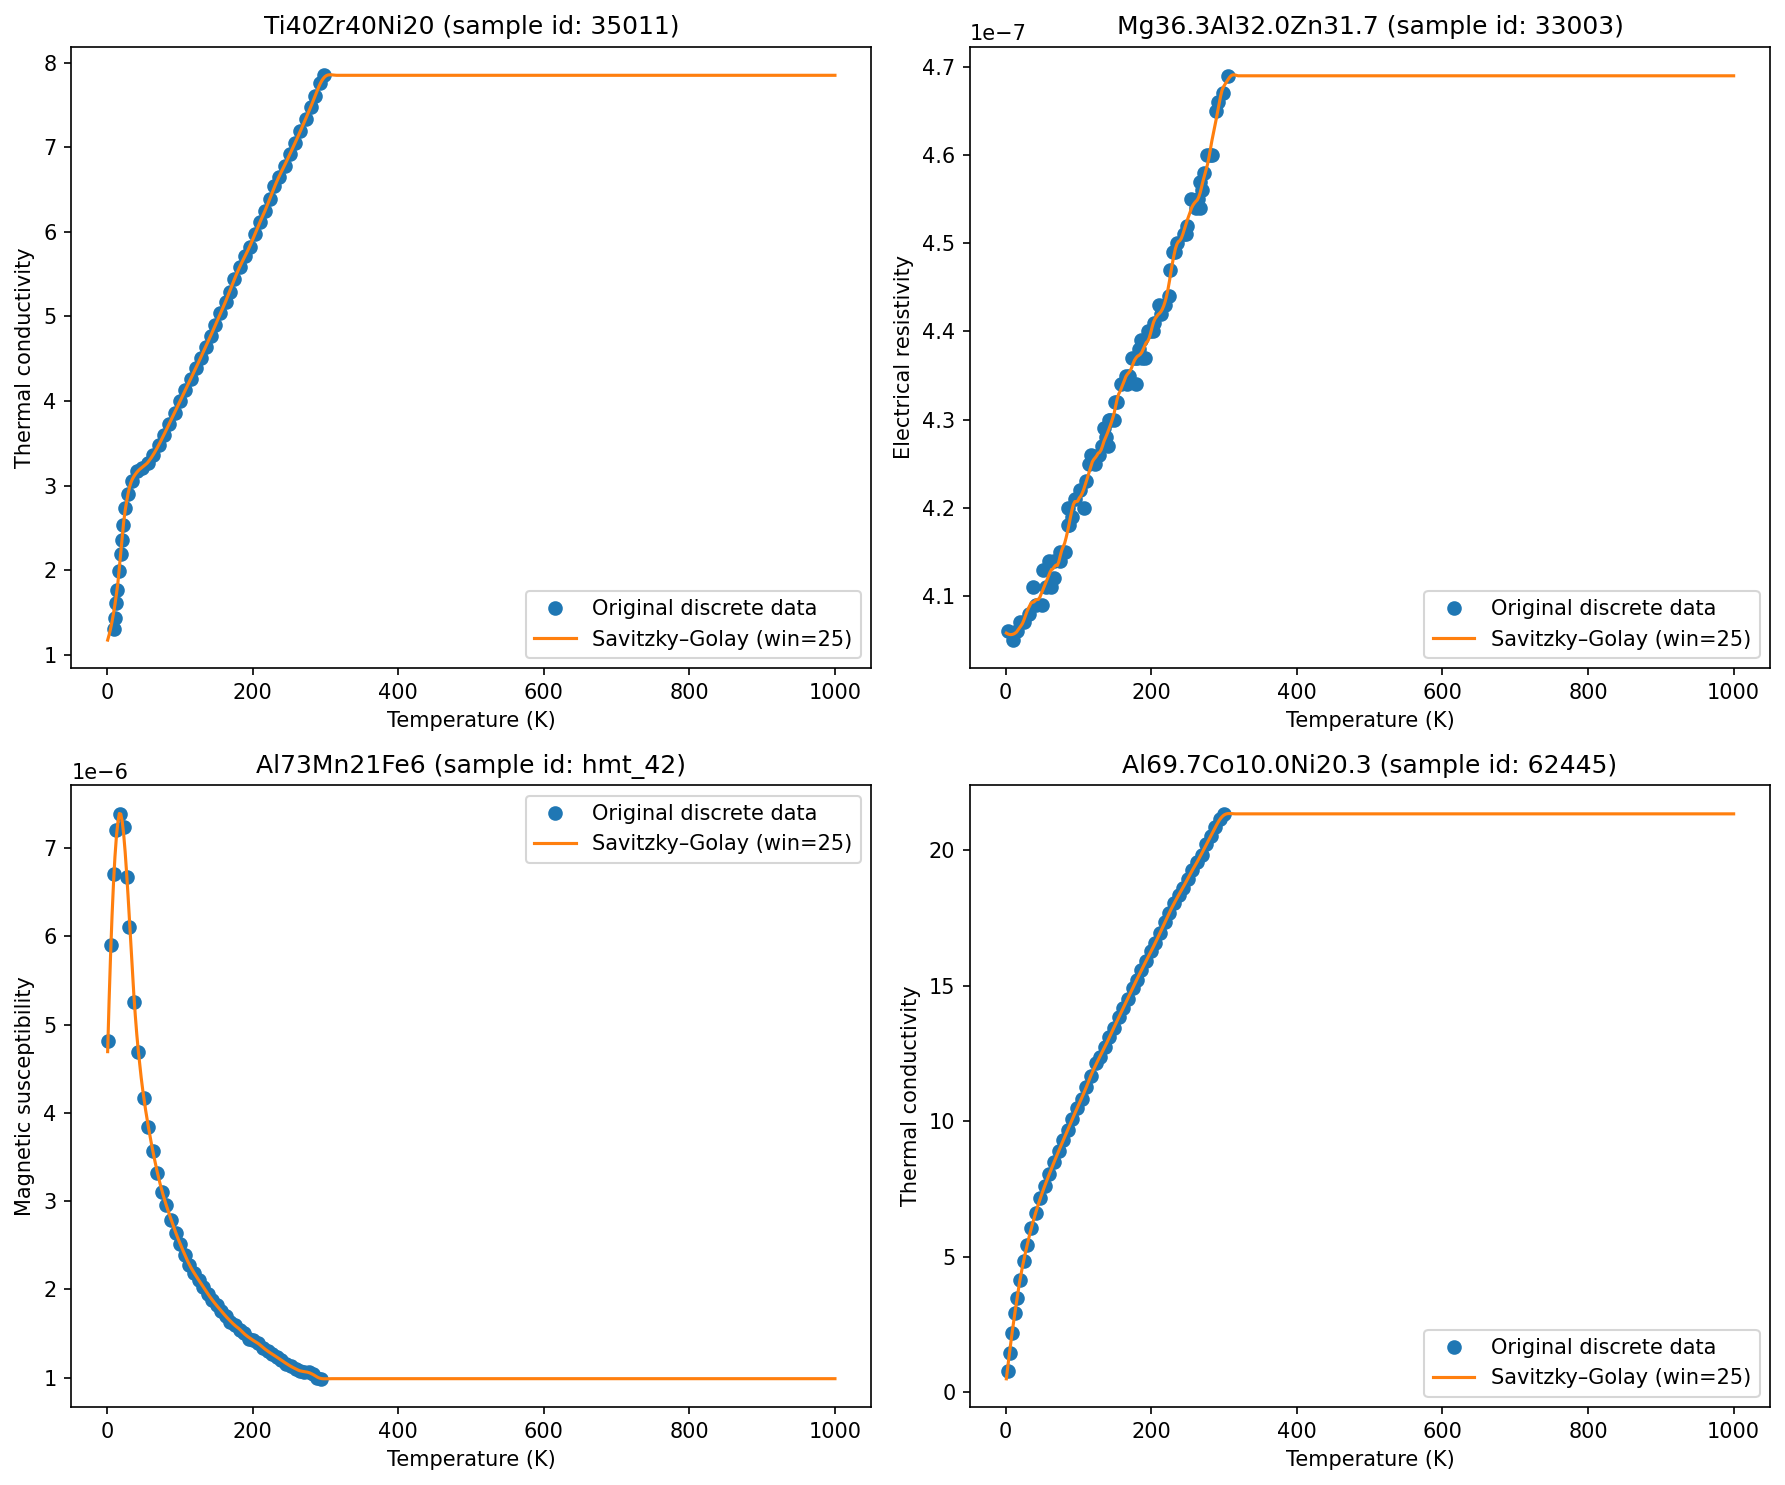

In [52]:
np.random.seed(8)  # 设置随机种子
# select_data = qc_ac_dataset_rebuild[qc_ac_dataset_rebuild.property.isin(["ZT", "Power factor"])]
select_data = qc_ac_dataset_rebuild
random_indices = np.random.choice(len(select_data), 4, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=150)
axes = axes.ravel()

for idx, i in enumerate(random_indices):
    tmp = select_data.iloc[i]
    y_new = tmp.property_value

    _ = axes[idx].plot(tmp.raw_x, tmp.raw_y, "o", label="Original discrete data")
    _ = axes[idx].plot(x_new, y_new, "-", lw=1.5, label="Savitzky–Golay (win=25)")
    _ = axes[idx].set_xlabel("Temperature (K)")
    _ = axes[idx].set_ylabel(tmp.property)
    _ = axes[idx].legend(loc="best")
    _ = axes[idx].set_title(f"{tmp.formula} (sample id: {tmp.sample_id})")

plt.tight_layout()
plt.show()


#### starry data

In [13]:
starry_dataset = pd.read_csv("../raw/starrydata_dataset_20250531/starrydata_curves.csv")
mask = starry_dataset.map(is_empty_list)
rows_to_drop = mask.any(axis=1)
starry_dataset = starry_dataset[~rows_to_drop]

starry_dataset = starry_dataset.rename(columns={"composition": "formula"})
starry_dataset = starry_dataset.assign(
    prop_x=starry_dataset.prop_x.apply(lambda s: format_title(s, to_snake=False)),
    prop_y=starry_dataset.prop_y.apply(lambda s: format_title(s, to_snake=False, skip_list=["ZT"])),
    unit_x=starry_dataset.unit_x.apply(lambda s: format_title(s, to_snake=False)),
    unit_y=starry_dataset.unit_y.apply(lambda s: format_title(s, to_snake=False)),
    x=starry_dataset.x.apply(eval),
    y=starry_dataset.y.apply(eval),
)

# Drop extremely small data
starry_dataset = starry_dataset[starry_dataset.unit_x == "K"]
starry_dataset = starry_dataset[~starry_dataset.unit_y.isin(["V", "V/k"])]
starry_dataset = starry_dataset[
    starry_dataset.prop_y.isin(
        [
            "Seebeck coefficient",
            "Thermal conductivity",
            "ZT",
            "Power factor",
            "Electrical resistivity",
            "Magnetic susceptibility",
        ]
    )
]
starry_dataset = starry_dataset[
    starry_dataset.prop_y.isin(starry_dataset.prop_y.unique()[starry_dataset.prop_y.value_counts() >= 100])
]

starry_dataset = starry_dataset[
    ~starry_dataset.sample_id.isin([int(i) for i in qc_ac_dataset.sample_id if not i.startswith("hmt")])
].assign(hypermaterial_type="others")
starry_dataset = starry_dataset[
    ["formula", "hypermaterial_type", "prop_x", "prop_y", "unit_x", "unit_y", "x", "y", "sample_id", "DOI"]
].dropna()

# Try to convert the composition string to the Composition object
starry_dataset = starry_dataset.assign(composition=starry_dataset["formula"].apply(convert_composition)).dropna(
    subset=["composition"]
)
starry_dataset = starry_dataset.assign(
    elements=starry_dataset.composition.apply(lambda c: tuple([str(e) for e in c.elements]))
)

# Align unit of Magnetic susceptibility
tmp = starry_dataset[(starry_dataset.unit_y == "emu*g^(-1)") | (starry_dataset.unit_y == "Emu/g")]
tmp = tmp.assign(
    unit_y="A*m**2/mol", y=[convert_mass_magnetization(comp, y).tolist() for comp, y in zip(tmp.composition, tmp.y)]
)
starry_dataset.update(tmp)

starry_dataset.unit_y.unique()
starry_dataset.prop_y.unique()
starry_dataset.head(3)
starry_dataset.shape

array(['V*k^(-1)', 'W*m^(-1)*k^(-1)', 'Ohm*m', 'W*m^(-1)*k^(-2)', '-',
       'A*m**2/mol'], dtype=object)

array(['Seebeck coefficient', 'Thermal conductivity',
       'Electrical resistivity', 'Power factor', 'ZT',
       'Magnetic susceptibility'], dtype=object)

,formula,hypermaterial_type,prop_x,prop_y,unit_x,unit_y,x,y,sample_id,DOI,composition,elements
0,Pb1.00025Zn0.02Te1.02I0.0005,others,Temperature,Seebeck coefficient,K,V*k^(-1),"[299.8597, 324.8683, 349.8757, 375.2454, 399.8...","[-0.0001484452, -0.0001602763, -0.0001729511, ...",113,10.1021/am405410e,"(Pb, Zn, Te, I)","(Pb, Zn, Te, I)"
1,Na0.0035Pb0.9965Se1,others,Temperature,Seebeck coefficient,K,V*k^(-1),"[317.7914, 379.1411, 384.0491, 431.9018, 452.7...","[7.27595e-05, 7.374922e-05, 9.257471e-05, 0.00...",147,10.1002/adma.201004200,"(Na, Pb, Se)","(Na, Pb, Se)"
2,Pb1.03Sb0.03Te1,others,Temperature,Seebeck coefficient,K,V*k^(-1),"[333.1159, 340.5494, 347.983, 355.4166, 362.85...","[-2.35374e-05, -2.455838e-05, -2.681692e-05, -...",434,10.1002/anie.200803934,"(Pb, Sb, Te)","(Pb, Sb, Te)"


(111261, 12)

In [81]:
start, end = 1.0, 1000.0
x_new = np.linspace(start, end, 500)  # pre-selected range = (-6,5, 10.5).

starry_dataset_rebuild = []
f_, p_ = "", ""
for (f, p, s), data in starry_dataset.groupby(["formula", "prop_y", "sample_id"]):
    data = data.iloc[0]
    if (f_, p_) == (f, p):
        continue
    if len(data.x) <= 10:
        continue
    if max(data.x) - min(data.x) < 50.0:
        continue
    f_, p_ = f, p

    interp = InterpSmooth(data.x, data.y, smooth_method="savgol")
    y_sgol = interp(x_new, s_factor=30.0)
    # y_sgol = interp(x_new, s_factor=30.0, normalize=True)

    tmp = data.copy()
    tmp["temperature"] = x_new.tolist()
    tmp["property_value"] = y_sgol.tolist()

    starry_dataset_rebuild.append(tmp)

starry_dataset_rebuild = (
    pd.DataFrame(starry_dataset_rebuild)
    .rename(columns={"prop_y": "property", "unit_y": "unit", "x": "raw_x", "y": "raw_y"})
    .drop(columns=["prop_x", "unit_x"])
)

# starry_dataset_rebuild.property = starry_dataset_rebuild.property.apply(lambda x: f"{x} (normalized)")
starry_dataset_rebuild = starry_dataset_rebuild.set_index(
    [[f"starry-{i}" for i in starry_dataset_rebuild.index]], drop=True
)
starry_dataset_rebuild.head(3)
starry_dataset_rebuild.shape
starry_dataset_rebuild.property.value_counts()

# Save the processed dataset
starry_dataset_rebuild.to_pickle("../processed_starrydata_dataset_20250531.pd.xz")

,formula,hypermaterial_type,property,unit,raw_x,raw_y,sample_id,DOI,composition,elements,temperature,property_value
starry-6210,\t(Pb0.92Mg0.08)0.98Na0.02Te0.8Se0.2,others,Seebeck coefficient,V*k^(-1),"[298.6339, 320.4918, 342.3497, 360.1093, 379.2...","[4.44379e-05, 5.668781e-05, 7.153834e-05, 8.63...",2717,10.1016/j.jmat.2016.05.005,"(Pb, Mg, Na, Te, Se)","(Pb, Mg, Na, Te, Se)","[1.0, 3.002004008016032, 5.004008016032064, 7....","[4.443789999999999e-05, 4.443789999999999e-05,..."
starry-6233,\t(Pb0.92Mg0.08)0.98Na0.02Te0.8Se0.2,others,ZT,-,"[821.843, 798.6348, 780.8874, 760.4096, 741.29...","[2.28777, 2.172662, 2.043165, 1.928058, 1.7985...",2717,10.1016/j.jmat.2016.05.005,"(Pb, Mg, Na, Te, Se)","(Pb, Mg, Na, Te, Se)","[1.0, 3.002004008016032, 5.004008016032064, 7....","[0.02158272999999999, 0.02158272999999999, 0.0..."
starry-5894,\t(Pb0.94Sr0.06)0.98Na0.02Te,others,Power factor,W*m^(-1)*k^(-2),"[339.6491, 374.7368, 425.2632, 470.1754, 522.1...","[0.0002236417, 0.0002840224, 0.00038486, 0.000...",2663,10.1016/j.jallcom.2016.06.172,"(Pb, Sr, Na, Te)","(Pb, Sr, Na, Te)","[1.0, 3.002004008016032, 5.004008016032064, 7....","[0.00022364169999999998, 0.0002236416999999999..."


(45312, 12)

property
Seebeck coefficient        14143
Electrical resistivity      8912
Thermal conductivity        8144
ZT                          7410
Power factor                6633
Magnetic susceptibility       70
Name: count, dtype: int64

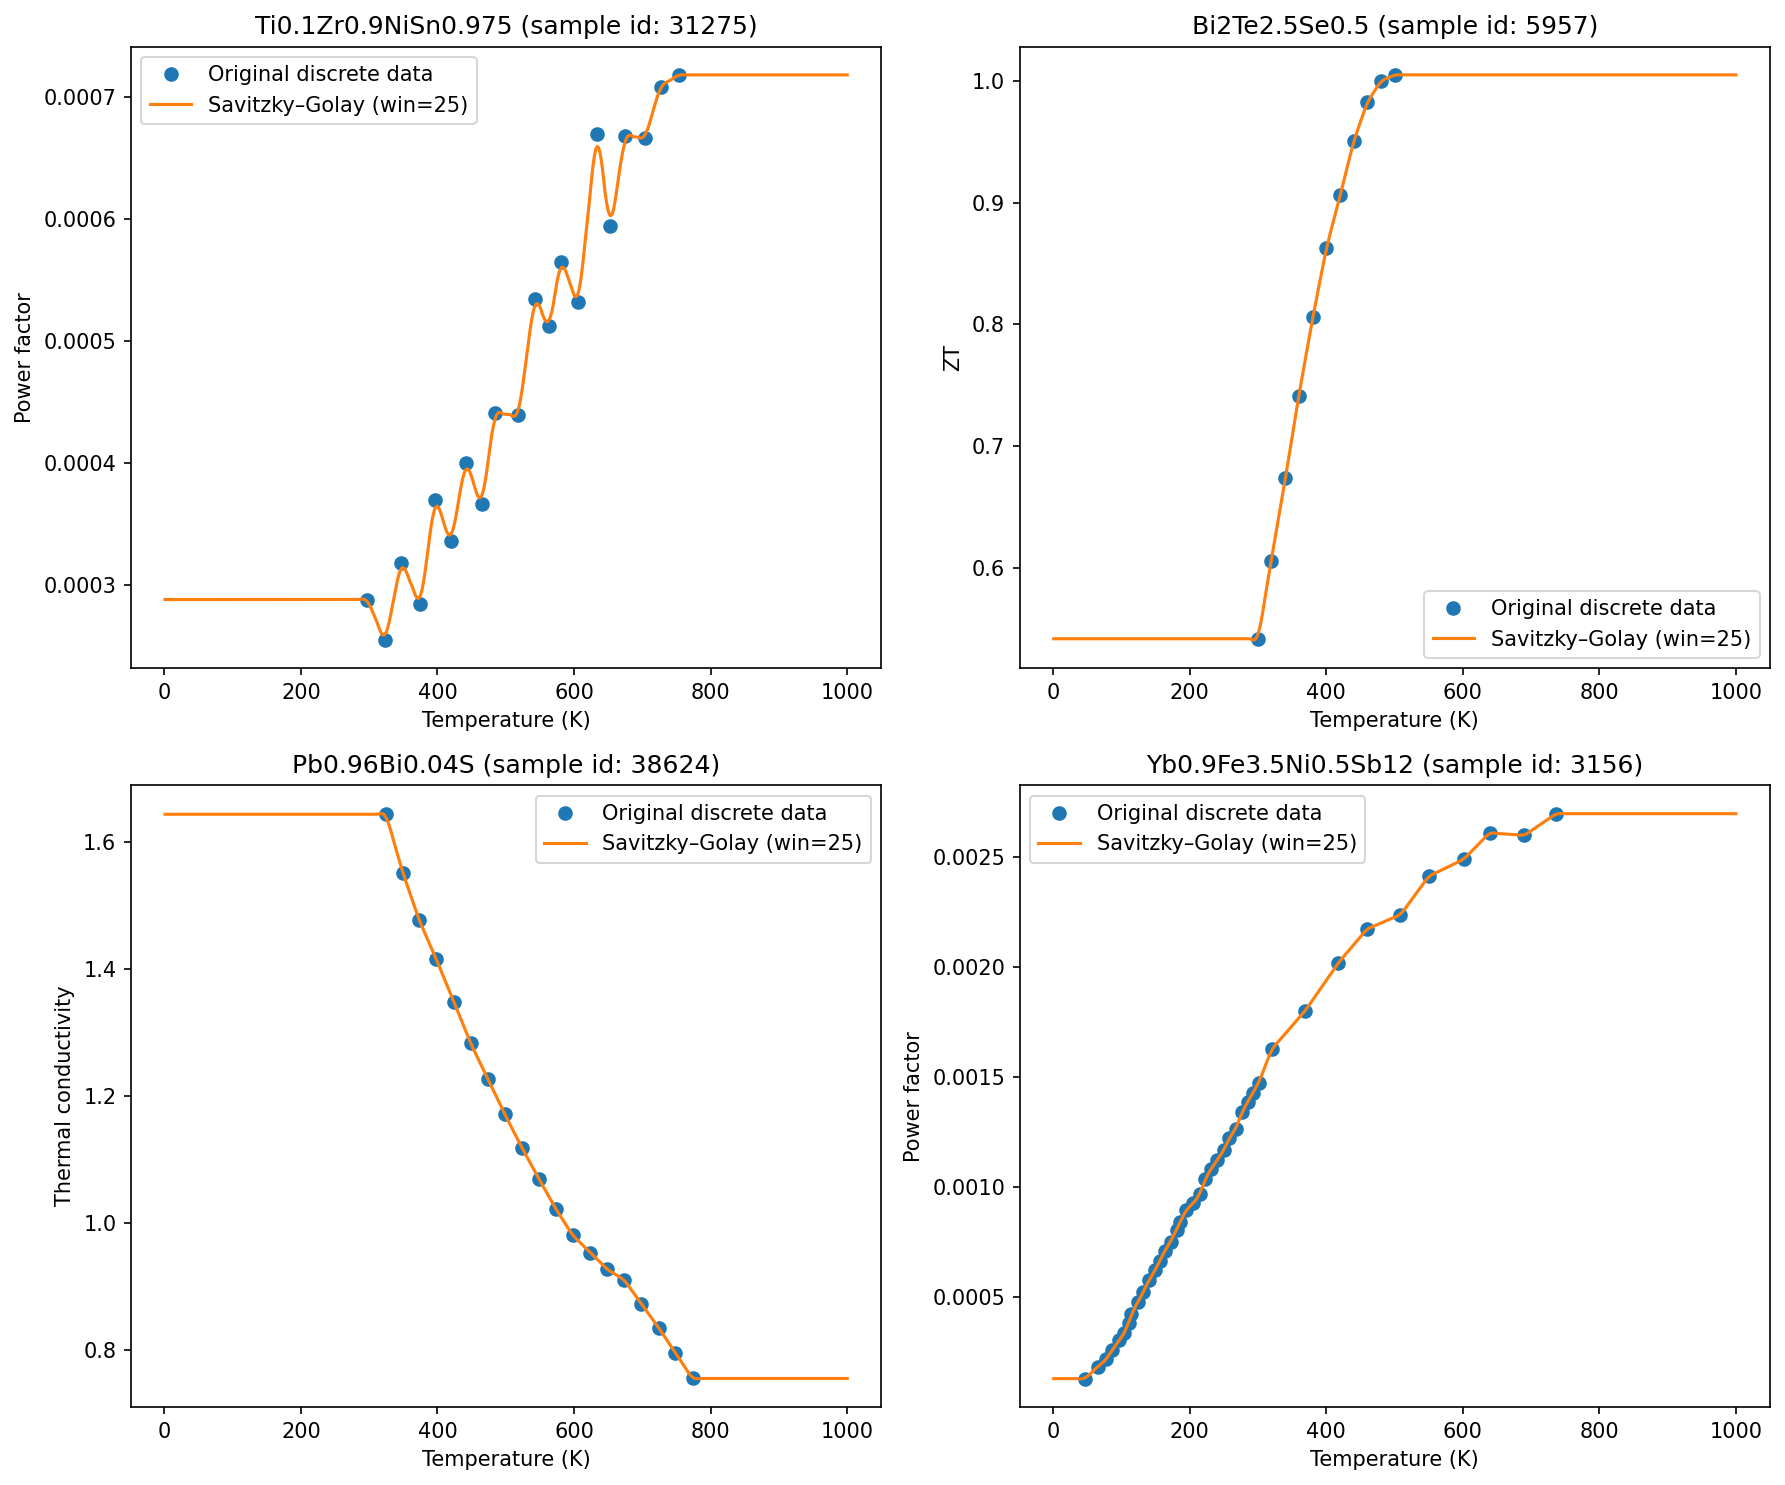

In [39]:
np.random.seed(4)  # 设置随机种子
random_indices = np.random.choice(len(starry_dataset_rebuild), 4, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=150)
axes = axes.ravel()

for idx, i in enumerate(random_indices):
    tmp = starry_dataset_rebuild.iloc[i]
    y_new = tmp.property_value

    _ = axes[idx].plot(tmp.raw_x, tmp.raw_y, "o", label="Original discrete data")
    _ = axes[idx].plot(x_new, y_new, "-", lw=1.5, label="Savitzky–Golay (win=25)")
    _ = axes[idx].set_xlabel("Temperature (K)")
    _ = axes[idx].set_ylabel(tmp.property)
    _ = axes[idx].legend(loc="best")
    _ = axes[idx].set_title(f"{tmp.formula} (sample id: {tmp.sample_id})")

plt.tight_layout()
plt.show()


### MP data

In [3]:
mp_props = [
    "band_gap",
    "composition",
    "density",
    "efermi",
    "elements",
    "energy_per_atom",
    "formation_energy_per_atom",
    "formula_pretty",
    "total_magnetization",
    "volume",
    "e_total",
    "symmetry",
]

mp_data = pd.read_pickle("../raw/materials_project_20250410/mp_inorganic_info.pd.xz")
mp_data = mp_data[mp_data.is_stable]
mp_data = mp_data[mp_props].rename(
    columns={"energy_per_atom": "final_energy_per_atom", "e_total": "dielectric_constant"}
)
mp_data = (
    mp_data.assign(
        space_group=mp_data.symmetry.apply(lambda s: s.get("symbol", None)),
        hypermaterial_type="others",
        composition=mp_data.composition.apply(convert_composition),
    )
    .dropna(subset=["composition"])
    .drop(columns=["symmetry"])
)

mp_data.shape
mp_data.head(3)

(33973, 13)

,band_gap,composition,density,efermi,elements,final_energy_per_atom,formation_energy_per_atom,formula_pretty,total_magnetization,volume,dielectric_constant,space_group,hypermaterial_type
material_id,,,,,,,,,,,,,
mp-862690,0.0,(Ac),8.170182,6.128110,[Ac],-68.637479,0.0,Ac,1.065000e-04,184.545401,NaN,P6_3/mmc,others
mp-8566,0.0,(Ag),10.315418,3.120110,[Ag],-21.355877,0.0,Ag,1.200000e-05,69.456950,NaN,P6_3/mmc,others
mp-87,0.0,(Be),1.882615,4.363531,[Be],-3.739413,0.0,Be,1.000000e-07,31.796370,NaN,P6_3/mmc,others


In [ ]:
mp_data_rebuild = []
units = {
    "band_gap": "eV",
    "density": "g*cm^(-3)",
    "efermi": "eV",
    "final_energy_per_atom": "eV/atom",
    "formation_energy_per_atom": "eV/atom",
    "total_magnetization": "µB/f.u.",
    "volume": "Å^3",
    "dielectric_constant": "-",
}
mp_props = [
    "band_gap",
    "density",
    "efermi",
    "final_energy_per_atom",
    "formation_energy_per_atom",
    "total_magnetization",
    "volume",
    "dielectric_constant",
]

for p in mp_props:
    data = (
        mp_data[["formula_pretty", "composition", "hypermaterial_type", "space_group", "elements", p]]
        .rename(columns={"formula_pretty": "formula", p: "property_value"})
        .dropna(subset=["property_value"])
    )
    data = data.assign(sample_id=0, DOI="-", unit=units[p], temperature=None, property=format_title(p, to_snake=False))
    mp_data_rebuild.append(data)

mp_data_rebuild = pd.concat(mp_data_rebuild)

mp_data_rebuild.head(3)
mp_data_rebuild.shape
mp_data_rebuild.property.value_counts()

,formula,composition,hypermaterial_type,space_group,elements,property_value,sample_id,DOI,unit,temperature,property
material_id,,,,,,,,,,,
mp-862690,Ac,(Ac),others,P6_3/mmc,[Ac],0.0,0,-,eV,None,Band gap
mp-8566,Ag,(Ag),others,P6_3/mmc,[Ag],0.0,0,-,eV,None,Band gap
mp-87,Be,(Be),others,P6_3/mmc,[Be],0.0,0,-,eV,None,Band gap


(242307, 11)

property
Band gap                     33973
Density                      33973
Final energy per atom        33973
Formation energy per atom    33973
Total magnetization          33973
Volume                       33973
Efermi                       33959
Dielectric constant           4510
Name: count, dtype: int64

### Merge dataset

In [82]:
qc_ac_te_mp_dataset = pd.concat([qc_ac_dataset_rebuild, starry_dataset_rebuild, mp_data_rebuild])

qc_ac_te_mp_dataset.sample(5)
qc_ac_te_mp_dataset.shape
qc_ac_te_mp_dataset.property.value_counts()

,formula,hypermaterial_type,property,unit,raw_x,raw_y,sample_id,DOI,composition,elements,temperature,property_value,space_group
mp-31426,HoInNi,others,Volume,Å^3,NaN,NaN,0,-,"(Ho, In, Ni)","[Ho, In, Ni]",None,176.789894,P-62m
mp-29372,Cs2GaSb2,others,Efermi,eV,NaN,NaN,0,-,"(Cs, Ga, Sb)","[Cs, Ga, Sb]",None,2.73638,Pnma
mp-21945,Ge3Ru2,others,Total magnetization,µB/f.u.,NaN,NaN,0,-,"(Ge, Ru)","[Ge, Ru]",None,0.0,Pbcn
mp-8898,TaAlO4,others,Volume,Å^3,NaN,NaN,0,-,"(Ta, Al, O)","[Al, O, Ta]",None,240.35321,Pbcn
mp-1191887,Cs2U(PdSe2)3,others,Formation energy per atom,eV/atom,NaN,NaN,0,-,"(Cs, U, Pd, Se)","[Cs, Pd, Se, U]",None,-1.117549,Fmmm


(288273, 13)

property
Band gap                     33973
Density                      33973
Final energy per atom        33973
Formation energy per atom    33973
Total magnetization          33973
Volume                       33973
Efermi                       33959
Seebeck coefficient          14284
Electrical resistivity        9273
Thermal conductivity          8216
ZT                            7423
Power factor                  6658
Dielectric constant           4510
Magnetic susceptibility        112
Name: count, dtype: int64

In [83]:
qc_ac_te_mp_rebuild = []

for (composition, hypermaterial_type), data in qc_ac_te_mp_dataset.groupby(["composition", "hypermaterial_type"]):
    row_1 = data.iloc[0]
    a = {
        "formula": row_1.formula,
        "hypermaterial_type": hypermaterial_type,
        "space_group": None,
        "temperature": None,
        "composition": composition,
        "elements": row_1.elements,
        "id": "",
    }
    for _id, row in data.iterrows():
        if _id.startswith("mp-"):
            a["id"] = _id
        elif _id.startswith("qa-") and not a["id"].startswith("mp-"):
            a["id"] = _id
        elif a["id"] == "":
            a["id"] = _id
        if row.space_group is not None:
            a["space_group"] = row.space_group
        a[row.property] = row.property_value
        a["temperature"] = row.temperature if row.temperature is not None else a["temperature"]

    qc_ac_te_mp_rebuild.append(a)

qc_ac_te_mp_rebuild = pd.DataFrame(qc_ac_te_mp_rebuild).set_index("id")
qc_ac_te_mp_rebuild.hypermaterial_type.value_counts()
qc_ac_te_mp_rebuild.space_group.value_counts()
qc_ac_te_mp_rebuild.shape
qc_ac_te_mp_rebuild.sample(10)

/data/foundation_model/.venv/lib/python3.12/site-packages/pymatgen/core/periodic_table.py:254: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  x1 = float("inf") if self.X != self.X else self.X
/data/foundation_model/.venv/lib/python3.12/site-packages/pymatgen/core/periodic_table.py:252: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  if not hasattr(other, "X") or not hasattr(other, "symbol"):
/data/foundation_model/.venv/lib/python3.12/site-packages/pymatgen/core/periodic_table.py:255: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  x2 = float("inf") if other.X != other.X else other.X
/data/foundation_model/.venv/lib/python

hypermaterial_type
others    50419
IQC         225
IAC         158
DQC          17
DAC          14
Name: count, dtype: int64

space_group
Fm-3m     3311
Pnma      2813
P2_1/c    2623
C2/c      1234
I4/mmm    1204
          ... 
Fd-3c        1
F222         1
Pban         1
Pcc2         1
P-4b2        1
Name: count, Length: 213, dtype: int64

(50833, 20)

,formula,hypermaterial_type,space_group,temperature,composition,elements,Band gap,Density,Efermi,Final energy per atom,Formation energy per atom,Total magnetization,Volume,Dielectric constant,Thermal conductivity,Electrical resistivity,Power factor,Seebeck coefficient,ZT,Magnetic susceptibility
id,,,,,,,,,,,,,,,,,,,,
mp-30340,ErInAg2,others,Fm-3m,None,"(Er, In, Ag)","[Ag, Er, In]",0.0000,10.067575,5.059808,-3.604849,-0.351657,0.000010,82.109007,NaN,NaN,NaN,NaN,NaN,NaN,NaN
starry-75819,Sr0.7Ba0.3Pb0.99Bi0.01O3,others,NaN,"[1.0, 3.002004008016032, 5.004008016032064, 7....","(Sr, Ba, Pb, Bi, O)","(Sr, Ba, Pb, Bi, O)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.00011278269999999993, 0.0001127826999999999...",NaN,NaN,NaN
mp-1359,NbIr,others,P4/mmm,None,"(Nb, Ir)","[Ir, Nb]",0.0000,14.752158,7.679709,-9.989488,-0.519618,0.000002,64.188372,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mp-9511,K2AsAuS4,others,P2_1/m,None,"(K, As, Au, S)","[As, Au, K, S]",0.9988,3.616202,1.083682,-4.222645,-0.878103,0.000000,439.306353,15.826084,NaN,NaN,NaN,NaN,NaN,NaN
starry-132286,Bi1.96Nb0.04O2Se,others,NaN,"[1.0, 3.002004008016032, 5.004008016032064, 7....","(Bi, Nb, O, Se)","(Bi, Nb, O, Se)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1.6206809999999994, 1.6206809999999992, 1.620...",NaN,"[7.378093999999996e-06, 7.378093999999996e-06,...","[-0.00036822859999999973, -0.00036822859999999...","[0.001502838999999999, 0.001502838999999999, 0...",NaN
starry-52673,Eu0.8La0.2B6,others,NaN,"[1.0, 3.002004008016032, 5.004008016032064, 7....","(Eu, La, B)","(Eu, La, B)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4.1798322732690395e-06, 4.002057036779162e-06...",NaN,NaN
starry-2154,Ba8Ni0.5Ge42.5,others,NaN,"[1.0, 3.002004008016032, 5.004008016032064, 7....","(Ba, Ni, Ge)","(Ba, Ni, Ge)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2.7851239999999975, 2.785123999999998, 2.7851...","[8.763157999999998e-06, 8.763157999999998e-06,...",NaN,"[-6.8062799999999964e-06, -6.806279999999997e-...","[-0.00014084509999999994, -0.00014084509999999...",NaN
mp-3301,Dy(SiPd)2,others,I4/mmm,None,"(Dy, Si, Pd)","[Dy, Pd, Si]",0.0000,8.467828,6.028950,-6.080429,-0.914674,0.000002,84.619207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mp-771977,TmAsO4,others,I4_1/amd,None,"(Tm, As, O)","[As, O, Tm]",3.5505,6.754634,1.323400,-7.682701,-2.858623,0.000000,151.363535,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
# DOS dataset
dos_data = pd.read_pickle("../dos_metal_processed_20240421.pd.xz")
dos_data.head(3)
dos_data.shape

# cols_to_take = ["energy", "density_norm"]
# dos_data = dos_data[cols_to_take].rename(columns={"energy": "DOS energy", "density_norm": "DOS density (normalized)"})
cols_to_take = ["energy", "density"]
dos_data = dos_data[cols_to_take].rename(columns={"energy": "DOS energy", "density": "DOS density"})
qc_ac_te_mp_dos_rebuild = qc_ac_te_mp_rebuild.join(dos_data, how="left")

qc_ac_te_mp_dos_rebuild.shape
qc_ac_te_mp_dos_rebuild.hypermaterial_type.value_counts()
qc_ac_te_mp_dos_rebuild.sample(15)

,reduced_formula,chemical_system,gap,efermi,is_stable,is_metal,density_raw,energy_raw,energy,density,density_norm
material_id,,,,,,,,,,,
mp-569794,Ta,Ta,0.0,5.264594,True,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-31.3333, -31.3103, -31.2873, -31.2643, -31.2...","[-6.0, -5.967935871743487, -5.935871743486974,...","[3.830508200593496, 3.9112246648565288, 3.9883...","[0.0620756786476286, 0.06338373727452007, 0.06..."
mp-62,Pa,Pa,0.0,13.102635,True,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-31.2563, -31.2271, -31.1979, -31.1687, -31.1...","[-6.0, -5.967935871743487, -5.935871743486974,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
mp-582819,Pu,Pu,0.0,14.873514,True,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-35.0145, -34.9817, -34.9489, -34.9161, -34.8...","[-6.0, -5.967935871743487, -5.935871743486974,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


(10726, 11)

(50833, 22)

hypermaterial_type
others    50419
IQC         225
IAC         158
DQC          17
DAC          14
Name: count, dtype: int64

,formula,hypermaterial_type,space_group,temperature,composition,elements,Band gap,Density,Efermi,Final energy per atom,...,Volume,Dielectric constant,Thermal conductivity,Electrical resistivity,Power factor,Seebeck coefficient,ZT,Magnetic susceptibility,DOS energy,DOS density
id,,,,,,,,,,,,,,,,,,,,,
mp-32311,Re2NiO8,others,P-3,None,"(Re, Ni, O)","[Ni, O, Re]",3.9632,4.875036,-1.818395,-8.408146,...,761.768087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mp-1067,LiAl,others,Fd-3m,None,"(Li, Al)","[Al, Li]",0.0000,1.779421,4.716816,-4.767881,...,63.312410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-6.0, -5.967935871743487, -5.935871743486974,...","[0.10606611833821486, 0.07314228472931442, 0.0..."
starry-76375,Bi0.94Sm0.06CuSeO,others,NaN,"[1.0, 3.002004008016032, 5.004008016032064, 7....","(Bi, Sm, Cu, Se, O)","(Bi, Sm, Cu, Se, O)",NaN,NaN,NaN,NaN,...,NaN,NaN,"[0.9242738999999995, 0.9242738999999995, 0.924...",NaN,"[0.0002063290999999998, 0.00020632909999999984...","[0.00020295359999999993, 0.0002029535999999999...","[0.06705538999999998, 0.06705538999999998, 0.0...",NaN,NaN,NaN
starry-180076,Nd0.6Ba0.4CoO3,others,NaN,"[1.0, 3.002004008016032, 5.004008016032064, 7....","(Nd, Ba, Co, O)","(Nd, Ba, Co, O)",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"[7.506599999999996e-05, 7.506599999999996e-05,...",NaN,NaN,NaN,NaN,NaN,NaN
mp-1208495,Tb3(P3Pd10)2,others,Fm-3m,None,"(Tb, P, Pd)","[P, Pd, Tb]",0.0000,10.213471,5.916408,-5.900175,...,453.772796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mp-1184999,LaMgAu2,others,Fm-3m,None,"(La, Mg, Au)","[Au, La, Mg]",0.0000,10.074229,5.997734,-4.008323,...,91.834201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mp-505312,Sr2FeCuSO3,others,P4/nmm,None,"(Sr, Fe, Cu, S, O)","[Cu, Fe, O, S, Sr]",0.0000,5.058794,3.980945,-6.484424,...,245.985259,20.611315,NaN,NaN,NaN,NaN,NaN,NaN,"[-6.0, -5.967935871743487, -5.935871743486974,...","[3.291874631401148, 2.7053021497006418, 2.2386..."
starry-160765,LaCo0.99Te0.01O3,others,NaN,"[1.0, 3.002004008016032, 5.004008016032064, 7....","(La, Co, Te, O)","(La, Co, Te, O)",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"[6826.999999999995, 6826.999999999995, 6826.99...",NaN,"[-3.240999999999999e-05, -3.240999999999999e-0...",NaN,NaN,NaN,NaN
mp-24288,LuH2,others,Fm-3m,None,"(Lu, H)","[H, Lu]",0.0000,9.465620,3.167061,-15.782377,...,31.047834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-6.0, -5.967935871743487, -5.935871743486974,...","[0.5946288050179543, 0.6193321510670005, 0.643..."


In [85]:
from sklearn.model_selection import train_test_split

train_idx, val_idx, test_idx = [], [], []

for prefix in ["qa-", "starry-", "mp-"]:
    data = qc_ac_te_mp_dos_rebuild[qc_ac_te_mp_dos_rebuild.index.str.startswith(prefix)]
    idx = data.index.tolist()
    n = len(idx)
    if n < 5:
        train_idx.extend(idx)
        continue
    idx_train, idx_temp = train_test_split(idx, test_size=0.3, random_state=42)
    idx_val, idx_test = train_test_split(idx_temp, test_size=0.5, random_state=42)
    train_idx.extend(idx_train)
    val_idx.extend(idx_val)
    test_idx.extend(idx_test)

split = pd.Series(index=qc_ac_te_mp_dos_rebuild.index, dtype="object")
split.loc[train_idx] = "train"
split.loc[val_idx] = "val"
split.loc[test_idx] = "test"
qc_ac_te_mp_dos_rebuild["split"] = split

qc_ac_te_mp_dos_rebuild.split.value_counts()
qc_ac_te_mp_dos_rebuild.sample(15)

qc_ac_te_mp_dos_rebuild.to_pickle("../qc_ac_te_mp_dos_reformat_20250529.pd.xz")

split
train    35582
test      7627
val       7624
Name: count, dtype: int64

,formula,hypermaterial_type,space_group,temperature,composition,elements,Band gap,Density,Efermi,Final energy per atom,...,Dielectric constant,Thermal conductivity,Electrical resistivity,Power factor,Seebeck coefficient,ZT,Magnetic susceptibility,DOS energy,DOS density,split
id,,,,,,,,,,,,,,,,,,,,,
starry-20273,Co9.2Ni0.8Sb30,others,NaN,"[1.0, 3.002004008016032, 5.004008016032064, 7....","(Co, Ni, Sb)","(Co, Ni, Sb)",NaN,NaN,NaN,NaN,...,NaN,"[1.3857499999999996, 1.3857499999999996, 1.385...",NaN,NaN,"[-2.1550189999999988e-05, -2.1550189999999988e...",NaN,NaN,NaN,NaN,train
mp-1228718,Ba3InIrRuO9,others,P6_3mc,None,"(Ba, In, Ir, Ru, O)","[Ba, In, Ir, O, Ru]",0.0000,7.283917,4.272641,-6.955293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-6.0, -5.967935871743487, -5.935871743486974,...","[19.57493861382533, 19.40984382785226, 19.2426...",train
starry-47283,In3.92Sn0.08Se3,others,NaN,"[1.0, 3.002004008016032, 5.004008016032064, 7....","(In, Sn, Se)","(In, Sn, Se)",NaN,NaN,NaN,NaN,...,NaN,"[1.015935, 1.015935, 1.015935, 1.015935, 1.015...",NaN,NaN,"[-4.8027569999999965e-05, -4.8027569999999965e...","[0.01787960999999999, 0.017879609999999994, 0....",NaN,NaN,NaN,train
mp-31073,Na3B7O12,others,P-1,None,"(Na, B, O)","[B, Na, O]",4.9219,2.407195,0.471130,-7.770030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
mp-1103317,SbRhS,others,P2_13,None,"(Sb, Rh, S)","[Rh, S, Sb]",0.8718,7.621355,7.312968,-19.962530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
mp-5808,RbNdTe2,others,R-3m,None,"(Rb, Nd, Te)","[Nd, Rb, Te]",1.2994,5.057869,2.538732,-4.624143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,val
starry-56767,Ba2HoCu2.7Co0.3O6,others,NaN,"[1.0, 3.002004008016032, 5.004008016032064, 7....","(Ba, Ho, Cu, Co, O)","(Ba, Ho, Cu, Co, O)",NaN,NaN,NaN,NaN,...,NaN,"[0.5200847991086496, 0.5159752822728837, 0.521...","[2.878386755556412e-08, 3.089838782057135e-08,...",NaN,"[1.7537608256653742e-05, 1.6736764339159104e-0...","[0.00016847919835158448, 0.0001610347980213807...",NaN,NaN,NaN,train
mp-5292,Ca(SiNi)2,others,I4/mmm,None,"(Ca, Si, Ni)","[Ca, Ni, Si]",0.0000,4.687806,6.728129,-5.499982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-6.0, -5.967935871743487, -5.935871743486974,...","[0.28592274671045204, 0.1975596878693435, 0.11...",train
mp-773199,Cs6Co2O7,others,P2_1/c,None,"(Cs, Co, O)","[Co, Cs, O]",1.1644,4.854589,1.518733,-5.091632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train


/var/folders/v6/kvz__tj532v10vqfjgv3snqm0000gn/T/ipykernel_50877/1159416111.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')


[Text(0, 0, 'Seebeck coefficient'),
 Text(1, 0, 'Thermal conductivity'),
 Text(2, 0, 'Electrical resistivity'),
 Text(3, 0, 'Magnetic susceptibility')]

Text(0, 0.5, 'Count')

Text(0.5, 0, '')

/var/folders/v6/kvz__tj532v10vqfjgv3snqm0000gn/T/ipykernel_50877/1159416111.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')


[Text(0, 0, 'Seebeck coefficient'),
 Text(1, 0, 'Thermal conductivity'),
 Text(2, 0, 'Electrical resistivity'),
 Text(3, 0, 'Magnetic susceptibility')]

Text(0.5, 0, '')

Text(0, 0.5, '')

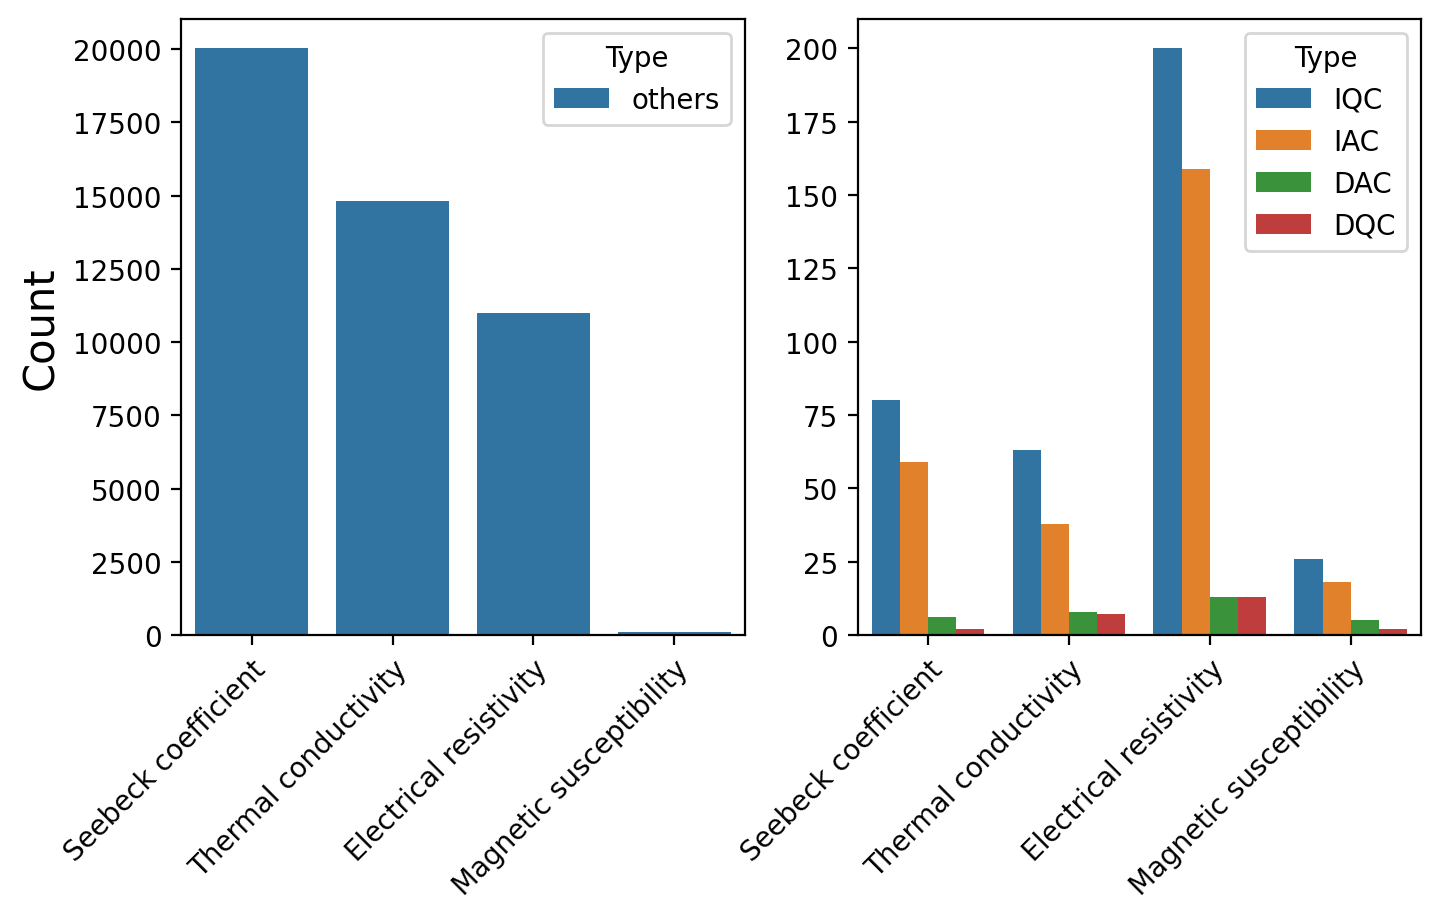

In [ ]:
tmp_ = qc_ac_te_mp_dataset.dropna(subset=["temperature"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=200, sharey=False)

tmp = tmp_[tmp_.hypermaterial_type == "others"]
ax = sns.countplot(tmp, x="property", hue="hypermaterial_type", ax=ax1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Count", fontsize=15)
ax.set_xlabel(None)
ax.legend(title="Type")

tmp = tmp_[tmp_.hypermaterial_type != "others"]
ax = sns.countplot(tmp, x="property", hue="hypermaterial_type", ax=ax2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.legend(title="Type")

---

(Thermal conductivity    5.199338
 dtype: float64,
 Thermal conductivity   -5.199338
 dtype: float64)

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

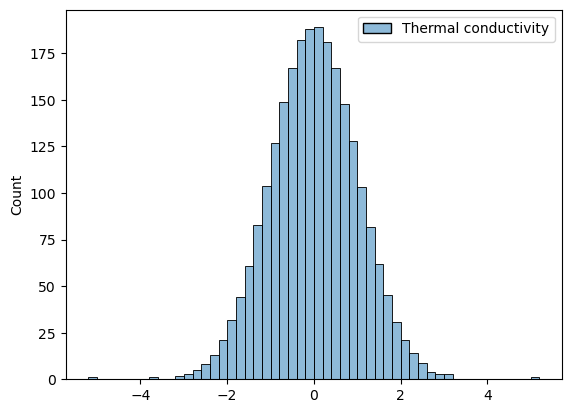

In [ ]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution="normal").set_output(transform="pandas")

a = qc_ac_te_mp_rebuild[["Thermal conductivity"]].dropna().astype(np.float64)
a = qt.fit_transform(a)
a.max(), a.min()
sns.histplot(a)

(Electrical resistivity    5.199338
 dtype: float64,
 Electrical resistivity   -5.199338
 dtype: float64)

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

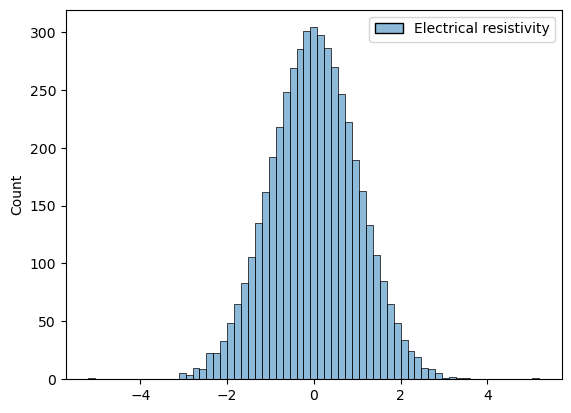

In [ ]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution="normal").set_output(transform="pandas")

a = qc_ac_te_mp_dos_rebuild[["Electrical resistivity"]].dropna().astype(np.float64)
a = qt.fit_transform(a)
a.max(), a.min()
sns.histplot(a)

(Seebeck coefficient    5.199338
 dtype: float64,
 Seebeck coefficient   -5.199338
 dtype: float64)

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

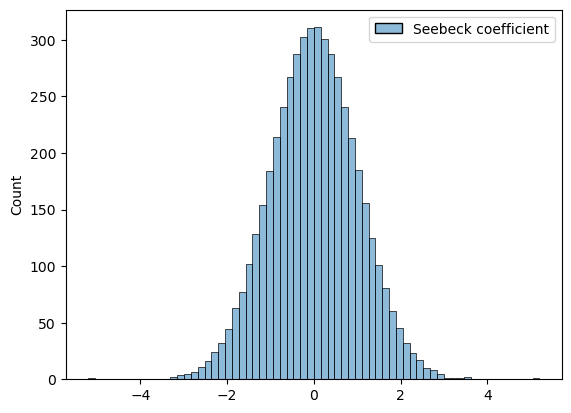

In [ ]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution="normal").set_output(transform="pandas")

a = qc_ac_te_mp_rebuild[["Seebeck coefficient"]].dropna().astype(np.float64)
a = qt.fit_transform(a)
a.max(), a.min()
sns.histplot(a)